# Colorization Network

## Imports

In [1]:
import os
import math
import random

import cv2

import PIL

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.color import lab2rgb, rgb2lab
from skimage import io

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset

from CustomData import ImageDataset

In [2]:
torch.set_default_tensor_type('torch.FloatTensor')

## Define Dataset

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

transformed_train_dataset = ImageDataset(root_dir='./TrainSet',
                                         transform=transform,
                                         regressor_only=False)
transformed_test_dataset = ImageDataset(root_dir='./TestSet',
                                        transform=transform,
                                        regressor_only=False)

## Train/Test Split

In [4]:
batch_size = 8

trainloader = torch.utils.data.DataLoader(transformed_train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(transformed_test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

## Plot some images

In [5]:
def imshow(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    npimg = npimg.astype('float32')
    plt.imshow(npimg)
    plt.show()

In [6]:
# get some random training images
dataiter = iter(trainloader)
images_gray, images_color, images_ab = dataiter.next()

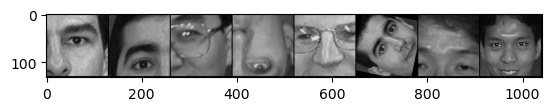

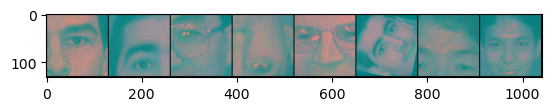

In [7]:
# show some images
imshow(torchvision.utils.make_grid(images_gray))
imshow(torchvision.utils.make_grid(images_color))

## Define network

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.downsample = nn.Sequential(
            nn.Conv2d(1, 8, 3, 2, 1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 32, 3, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(128, 32, 2, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 8, 2, 2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 2, 2, 2),
            nn.ReLU()
            #nn.Tanh()
        )

    def forward(self, x):
        midlevel = self.downsample(x)
        output = self.upsample(midlevel)
        return output

net = Net()

### Move to cuda if possible

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
print(device)

cuda:0


## Define optimizer

In [36]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=0.0)

## Train

In [47]:
num_mini_batch_print = 50
early_stopping_threshhold = 0.0001
early_stop = False
min_loss = None
loss_history = []

for epoch in range(1):  # loop over the dataset multiple times
    # Perform early stopping if loss change is below threshhold
    if early_stop:
        print(f'---EARLY STOPPING w/ THRESHOLD {early_stopping_threshhold}---')
        break
    
    print(f'----epoch: {epoch + 1}')
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images_gray, images_color, images_ab = data[0].to(device), data[1].to(device), data[2].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(images_gray)
        loss = criterion(outputs, images_ab)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        # print current current running loss every so many mini-batches
        if i % num_mini_batch_print == num_mini_batch_print - 1:
            avg_loss_minibatches = running_loss / num_mini_batch_print
            
            print('[%d, %5d] current running loss: %.5f' %
                  (epoch + 1, i + 1, avg_loss_minibatches))
            
            loss_history.append({'num_minibatches': i + 1, 'avg_loss': avg_loss_minibatches})
            running_loss = 0
            
            if min_loss is None or avg_loss_minibatches < min_loss:
                min_loss = avg_loss_minibatches
                

print('Finished Training')

----epoch: 1
[1,    50] current running loss: 0.00042
[1,   100] current running loss: 0.00040
[1,   150] current running loss: 0.00036
[1,   200] current running loss: 0.00037
[1,   250] current running loss: 0.00037
[1,   300] current running loss: 0.00041
[1,   350] current running loss: 0.00038
[1,   400] current running loss: 0.00038
[1,   450] current running loss: 0.00044
[1,   500] current running loss: 0.00039
[1,   550] current running loss: 0.00035
[1,   600] current running loss: 0.00038
[1,   650] current running loss: 0.00040
[1,   700] current running loss: 0.00038
[1,   750] current running loss: 0.00043
[1,   800] current running loss: 0.00038
Finished Training


## Save Model

In [48]:
PATH = './colorize_net.pth'
torch.save(net.state_dict(), PATH)

## Evaluate Model
### Peak at 4 test examples

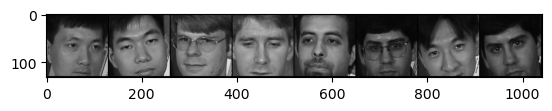

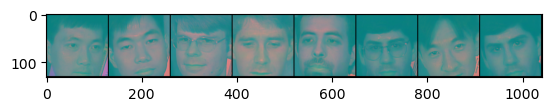

In [49]:
dataiter = iter(testloader)
images_gray, images_color, images_ab = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images_gray))
imshow(torchvision.utils.make_grid(images_color))

### Look at model performance on these examples

In [50]:
outputs = net(images_gray.to(device)).cpu()

### Combine l, a and b channels

In [51]:
outputs = torch.cat((images_gray, outputs), 1)

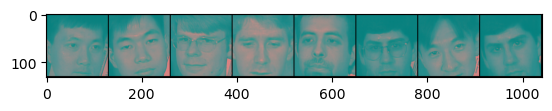

In [52]:
imshow(torchvision.utils.make_grid(outputs))

## Convert Tensor output to RGB

In [53]:
def tensor_to_rgb(tensors):
    images_RGB = []

    for tensor in tensors:
        color_image = tensor.detach().clone().numpy()
        color_image = np.transpose(color_image, (1,2,0))
        color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
        color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
        color_image = lab2rgb(color_image.astype(np.float64))
        color_image = np.transpose(color_image, (2,0,1))
        images_RGB.append(color_image)

    return torch.tensor(np.array(images_RGB))

Input:


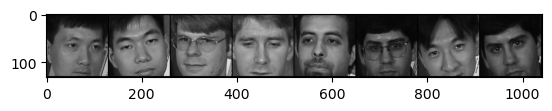

Ground truth:


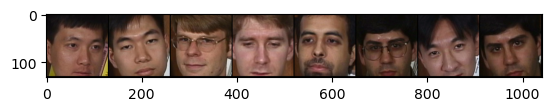

Colorize Net outputs:


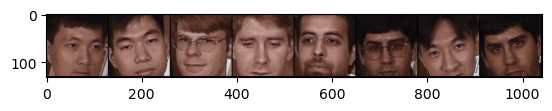

In [54]:
print('Input:')
imshow(torchvision.utils.make_grid(images_gray))
print('Ground truth:')
imshow(torchvision.utils.make_grid(tensor_to_rgb(images_color)))
print('Colorize Net outputs:')
imshow(torchvision.utils.make_grid(tensor_to_rgb(outputs)))

## Evaluate performance on whole test set

In [55]:
test_loss = []

with torch.no_grad():
    for data in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        images_gray, images_color, images_ab = data[0].to(device), data[1].to(device), data[2].to(device)

        # forward + backward + optimize
        outputs = net(images_gray)
        
        for i, output in enumerate(outputs):
            loss = criterion(output, images_ab[i])
            test_loss.append(loss)

        # print statistics
        running_loss += loss.item()

In [56]:
print(f'Average test loss: {torch.mean(torch.tensor(test_loss))}')

Average test loss: 0.000349024950992316
